In [9]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Data Inspection
Load the data and ispect it

In [2]:
with open("data/train/COCO_mul_train_annos.json") as f:
    data = json.load(f)

df_annotations = pd.json_normalize(data["annotations"])
# keys = ["image_id", "area", "bbox", "segmentation", "category_id"]
df_imgs = pd.json_normalize(data["images"])
df_categories = pd.json_normalize(data["categories"])
# df_annotations = df_annotations[keys]
display(df_annotations.head())
display(df_imgs.head())
display(df_categories.head())
print("Number of annotations:", len(df_annotations))
print("Number of images:", len(df_imgs))
print("Number of categories:", len(df_categories))

,area,bbox,category_id,id,image_id,iscrowd,segmentation
0,695590.0,"[3, 3, 879, 677]",3,0,0,0,"[[3, 3, 774, 4, 863, 133, 882, 170, 878, 206, ..."
1,10202.5,"[707, 311, 266, 533]",1,1,1,0,"[[748, 311, 837, 337, 946, 348, 966, 380, 973,..."
2,15408.0,"[189, 294, 831, 727]",2,2,1,0,"[[212, 294, 195, 369, 189, 471, 192, 556, 211,..."
3,1289455.0,"[1, 3, 763, 456]",4,3,2,0,"[[4, 341, 1, 3, 764, 4, 753, 34, 633, 77, 609,..."
4,15168.0,"[409, 41, 373, 511]",1,4,2,0,"[[759, 41, 782, 62, 758, 150, 676, 427, 651, 4..."


,coco_url,date_captured,file_name,flickr_url,height,id,license,width
0,,2020-07-14 09:59:34.190485,10.jpg,,1024,0,1,1024
1,,2020-07-14 09:59:34.190485,13.jpg,,1024,1,1,1024
2,,2020-07-14 09:59:34.190485,14.jpg,,1024,2,1,1024
3,,2020-07-14 09:59:34.190485,15.jpg,,1024,3,1,1024
4,,2020-07-14 09:59:34.190485,16.jpg,,1024,4,1,1024


,id,name,supercategory
0,1,headlamp,part
1,2,rear_bumper,part
2,3,door,part
3,4,hood,part
4,5,front_bumper,part


Number of annotations: 177
Number of images: 59
Number of categories: 5


As you can see, an image can have different annotation and we will check the reason after. Now, merge all the three dataframe in one.

Let's start by merging categories. This will bring to another preprocessing before training, but we are ok with it. We just have all the information in the same place

In [3]:
catid_to_cat = df_categories[["id", "name"]].to_dict()["name"]
df_annotations["category_id"] = df_annotations["category_id"].replace(catid_to_cat)
df_annotations.head()

,area,bbox,category_id,id,image_id,iscrowd,segmentation
0,695590.0,"[3, 3, 879, 677]",hood,0,0,0,"[[3, 3, 774, 4, 863, 133, 882, 170, 878, 206, ..."
1,10202.5,"[707, 311, 266, 533]",rear_bumper,1,1,0,"[[748, 311, 837, 337, 946, 348, 966, 380, 973,..."
2,15408.0,"[189, 294, 831, 727]",door,2,1,0,"[[212, 294, 195, 369, 189, 471, 192, 556, 211,..."
3,1289455.0,"[1, 3, 763, 456]",front_bumper,3,2,0,"[[4, 341, 1, 3, 764, 4, 753, 34, 633, 77, 609,..."
4,15168.0,"[409, 41, 373, 511]",rear_bumper,4,2,0,"[[759, 41, 782, 62, 758, 150, 676, 427, 651, 4..."


Finally, merge also image file information and obtain the final dataframe

In [7]:
imgid_to_img = df_imgs[["id", "file_name"]].to_dict()["file_name"]

df_annotations["image_id"] = df_annotations["image_id"].replace(imgid_to_img)
df_annotations = df_annotations.rename(columns={"image_id": "image_ref", "category_id": "category"})
df_annotations["segmentation"] = df_annotations["segmentation"].apply(lambda s: s[0])

df = df_annotations[["image_ref", "area", "bbox", "segmentation", "category"]]
display(df.head())
print("Number of annotations:", len(df))
print("Number of images:", len(df["image_ref"].unique()))
print("Number of categories:", len(df["category"].unique()))

,image_ref,area,bbox,segmentation,category
0,10.jpg,695590.0,"[3, 3, 879, 677]","[3, 3, 774, 4, 863, 133, 882, 170, 878, 206, 8...",hood
1,13.jpg,10202.5,"[707, 311, 266, 533]","[748, 311, 837, 337, 946, 348, 966, 380, 973, ...",rear_bumper
2,13.jpg,15408.0,"[189, 294, 831, 727]","[212, 294, 195, 369, 189, 471, 192, 556, 211, ...",door
3,14.jpg,1289455.0,"[1, 3, 763, 456]","[4, 341, 1, 3, 764, 4, 753, 34, 633, 77, 609, ...",front_bumper
4,14.jpg,15168.0,"[409, 41, 373, 511]","[759, 41, 782, 62, 758, 150, 676, 427, 651, 49...",rear_bumper


Number of annotations: 177
Number of images: 59
Number of categories: 5


All the modification haven't modify the data structure. Now, let plot some image example and try to understand why some images have multimple annotations.

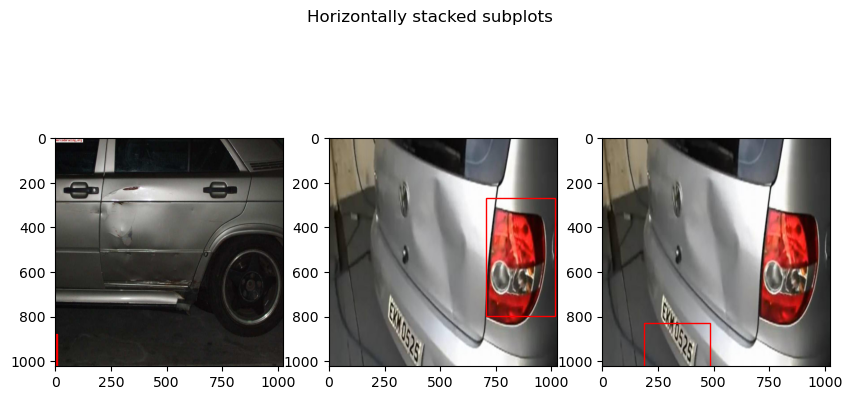

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Horizontally stacked subplots')
for i in range(3):
    row = df.iloc[i]
    img = Image.open(f"data/train/{row['image_ref']}")
    axs[i].imshow(img)
    bbox = row["bbox"]
    rect = patches.Rectangle((bbox[0], bbox[2]), bbox[1], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    axs[i].add_patch(rect)
plt.show()